In [1]:
import glob
import h5py
import numpy as np
from torch.utils.data import *
from collections.abc import Iterable
from data_utils import *
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from vq_unet_model import VQ_Unet

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

## Define Dataset

In [2]:
root = '/home/featurize/data/Generate_Data_Step_0_496_264_20020601_20190409.mat'
train_dataset = MyDataset(root, mode='train', in_channels=16, out_channels=4, steps=1, skip=5)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8)+1, int(len(dataset) * 0.2)])
val_dataset = MyDataset(root, mode='test', in_channels=16, out_channels=4, steps=1, skip=5)

In [3]:
batch_size = 4
device = 'cuda'

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=6, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=6, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=6, shuffle=False)

In [4]:
model = VQ_Unet(in_channels=16,out_channels=4)

## Training

In [5]:
logger = TensorBoardLogger("log", name="version-16-4-skip5")
callbacks = [
    EarlyStopping(monitor='mse_loss', patience=20, mode='min', check_on_train_epoch_end=False), 
    ModelCheckpoint(dirpath='./checkpoints/', filename='vqunet-16-4-5-{epoch:02d}-{val_loss:.2f}', monitor='mse_loss', mode='min', save_top_k=3, verbose=True)
    ]

In [6]:
trainer = pl.Trainer(gpus=1, callbacks=callbacks, logger=logger)

/home/featurize/work/.local/lib/python3.7/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
# trainer.fit(model, train_loader, val_loader, ckpt_path='log/version-16-4-skip5/version_1/checkpoints/epoch=16-step=20519.ckpt')
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name     | Type        | Params
------------------------------------------
0  | enc1     | DenseBlock  | 276 K 
1  | enc2     | Sequential  | 763 K 
2  | enc3     | Sequential  | 1.4 M 
3  | enc4     | Sequential  | 1.6 M 
4  | enc5     | Sequential  | 1.6 M 
5  | enc6     | Sequential  | 1.6 M 
6  | enc7     | Sequential  | 1.6 M 
7  | enc8     | Sequential  | 1.6 M 
8  | bridge   | Sequential  | 147 K 
9  | codebook | VQEmbedding | 65.5 K
10 | dec8     | Sequential  | 147 K 
11 | dec7_1   | UpConvBlock | 147 K 
12 | dec7_2   | Sequential  | 295 K 
13 | dec6_1   | UpConvBlock | 147 K 
14 | dec6_2   | Sequential  | 295 K 
15 | dec5_1   | UpConvBlock | 147 K 
16 | dec5_2   | Sequential  | 295 K 
17 | dec4_1   | UpConvBlock | 147 K 
18 | dec4_2   | Sequential  | 295 K 
19 | dec3_1   | UpConvBlock | 147 K 
20 | dec3_2   | Sequential  | 295 K 
21 | dec2_1   | UpConvBlock | 147 K 
22 | dec2_2   | Sequential  | 258 K 
23 | dec1_1   | UpConvBloc

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/featurize/work/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:727: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Testing

In [5]:
checkpoint = '/home/featurize/work/SST-Forecast/vq-unet/checkpoints/version-16-4-skip5-fullscale-loss1/checkpoint-1/vqunet-16-4-5-epoch=35-val_mse=0.001.ckpt'
model = VQ_Unet.load_from_checkpoint(checkpoint, in_channels=16,out_channels=4)

In [6]:
x, y = next(iter(val_loader))
model.eval()
preds = model(x)

In [7]:
# print(x.shape, y.shape)
# preds, targets = learn.get_preds(2)
pred_idx = 2
pred = preds[0][pred_idx].cpu().detach().numpy()
print(pred.shape)

(4, 264, 496)


In [8]:
label = y[pred_idx].cpu().detach().numpy()
print(label.shape)

(4, 264, 496)


In [9]:
input = x[0].cpu().detach().numpy()

In [10]:
pred = recover(pred, 17., 32.)
label = recover(label, 17., 32.)
input = recover(input, 17., 32.)

In [11]:
print(pred[:,0,0])
print(label[:,0,0])

[24.098671 23.870695 23.661417 24.22256 ]
[23.6425 24.3    24.655  25.2125]


In [12]:
# diff = abs(pred - label)
diff = pred-label

In [13]:
print(np.max(diff), np.min(diff))

2.7967892 -3.835764


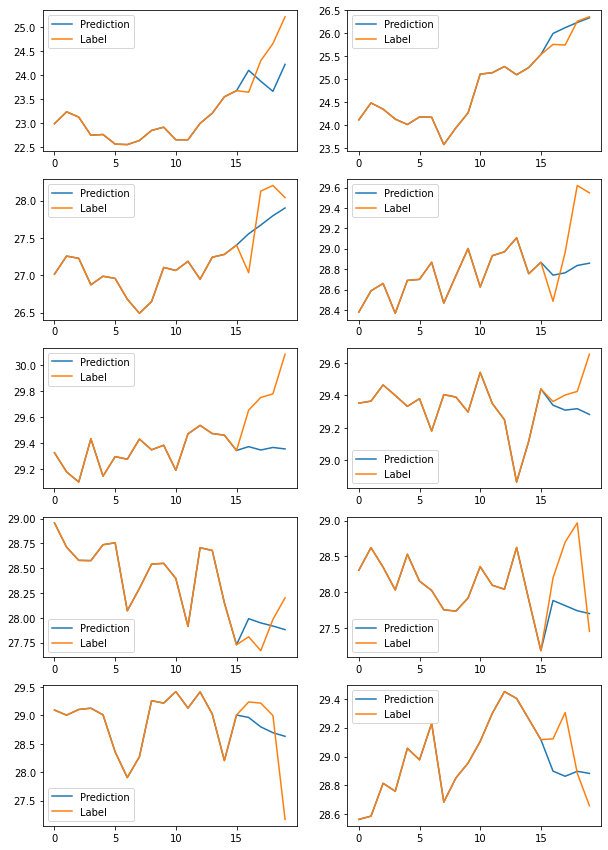

In [14]:
# idx = [100, 250]
plt.figure(figsize=(10,15))
for idx in range(10):
    i = idx*20
    plt.subplot(5,2,idx+1)
    plt.plot(np.concatenate([input[...,i, i], pred[...,i, i]]))
    plt.plot(np.concatenate([input[...,i, i],label[...,i, i]]))
    plt.legend(['Prediction', 'Label'])
plt.savefig('./results/loss1/ver2/vqunet-16-4-5-fullscale-epoch=35-point.png')

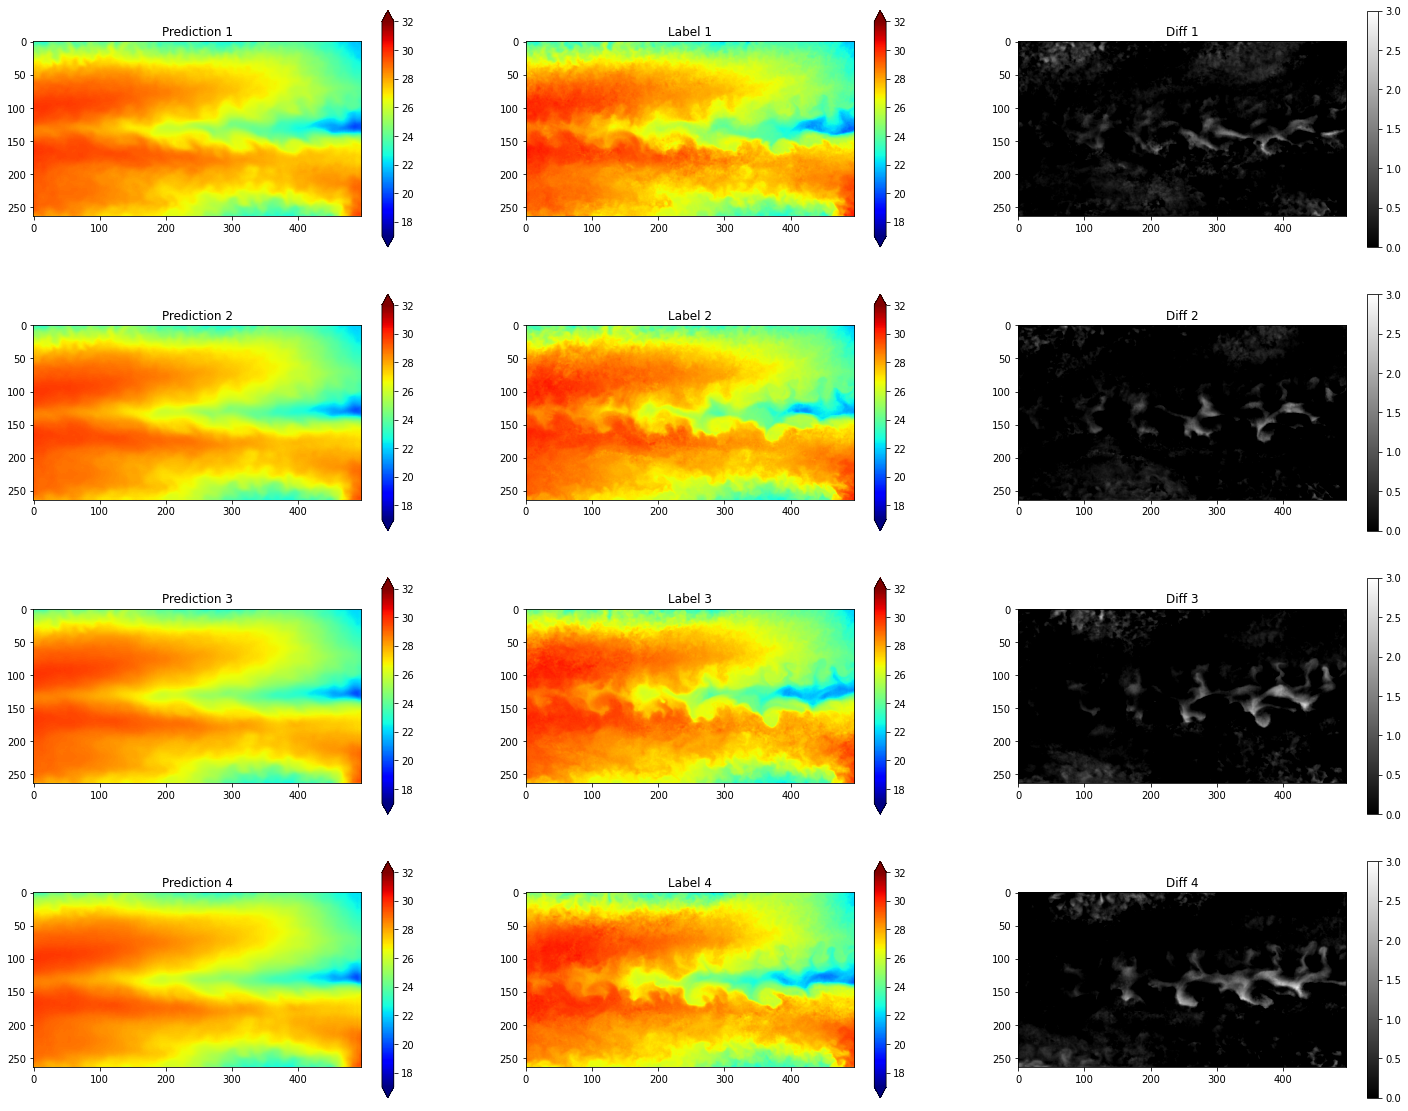

In [15]:
plt.figure(figsize=(25,20))
len = pred.shape[0]
for i in range(len):
    plt.subplot(len, 3, i*3+1)
    plt.imshow(pred[i], cmap='jet', vmax=32, vmin=17)
    plt.title('Prediction {}'.format(i+1))
    plt.colorbar(extend='both')
    plt.subplot(len, 3, i*3+2)
    plt.imshow(label[i], cmap='jet', vmax=32, vmin=17)
    plt.title('Label {}'.format(i+1))
    plt.colorbar(extend='both')
    plt.subplot(len, 3, i*3+3)
    plt.imshow(diff[i], cmap='gray', vmin=0, vmax=3)
    plt.title('Diff {}'.format(i+1))
    plt.colorbar()
plt.savefig('./results/loss1/ver2/vqunet-16-4-5-fullscale-epoch=35-region.png')
